# 电化学部分的建模使用拟合经验模型的方法

## import需要的库

In [1]:
import os,gzip,pickle
from keys import DataDir,Cols
import numpy as np
import pandas as pd
import torch
from torch.utils.data import random_split
import math
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 设置字体
matplotlib.rcParams['font.family'] = 'Microsoft YaHei, Times New Roman'
# 全局设置字号
plt.rcParams.update({
    'font.size': 16,  # 基础字号
    'axes.titlesize': 20,  # 标题字号
    'axes.labelsize': 20,  # 坐标轴标签字号
    'xtick.labelsize': 20,  # x轴刻度标签字号
    'ytick.labelsize': 20,  # y轴刻度标签字号
    'legend.fontsize': 16  # 图例字号
})
# 解决负号显示问题
matplotlib.rcParams['axes.unicode_minus'] = False

## 导入数据与数据预处理

In [64]:
with gzip.open(
    r'D:\Devs\Single_Stack_MLJ\data\processed\Test data Hyzenis\2025.04.08-8.30-2025.04.11-17.30-10s-1# gzip',
    'rb'
) as f:
    df_Hyzenis = pickle.load(f)

In [65]:
df_date_Hyzenis = df_Hyzenis.query(
    f"'2025-04-08 12:00:00'<{Cols.date_time}<'2025-04-10 12:00:00'"
)

In [66]:
df_date_Hyzenis[Cols.lye_flow] = df_date_Hyzenis[Cols.lye_flow].rolling(window=10, min_periods=1, center=True).mean()  # min_periods=1 确保首个数据直接保留

C:\Users\Orz\AppData\Local\Temp\ipykernel_9296\2816558963.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_date_Hyzenis[Cols.lye_flow] = df_date_Hyzenis[Cols.lye_flow].rolling(window=10, min_periods=1, center=True).mean()  # min_periods=1 确保首个数据直接保留


### 筛选数据点

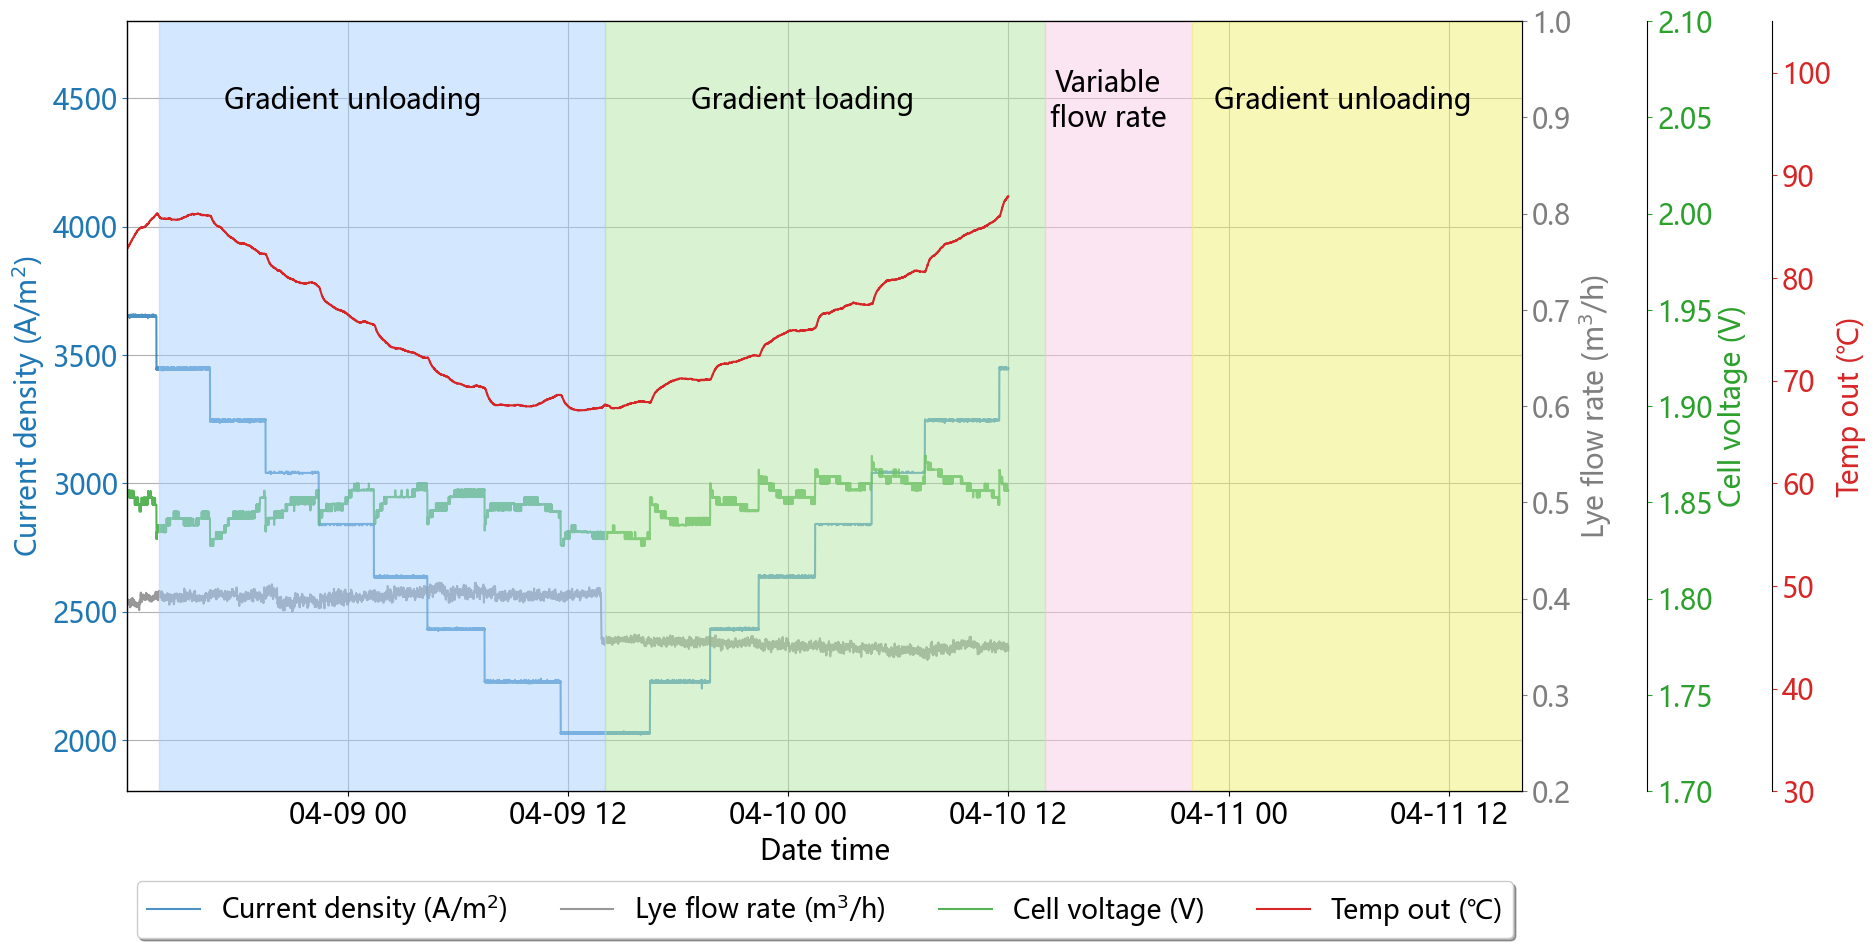

In [60]:
# 创建图表和子图
fig, ax1 = plt.subplots(figsize=(18, 10))
# plt.title('原始数据', fontsize = 15)
plt.grid(True)

# 绘制碱液流量曲线
ax1.plot(df_date_Hyzenis[Cols.date_time], df_date_Hyzenis[Cols.current_density], c = '#1f77b4', alpha = 0.8,label = 'Current density (A/m$^2$)')
ax1.set_ylabel('Current density (A/m$^2$)', color='#1f77b4')
ax1.margins(x=0)  # 仅消除x轴边距
ax1.set_xlabel('Date time')
ax1.tick_params('y', colors='#1f77b4')
ax1.set_ylim((1800, 4800))

# 创建第二个y轴
ax2 = ax1.twinx()

# 绘制第电流曲线
ax2.plot(df_date_Hyzenis[Cols.date_time], df_date_Hyzenis[Cols.lye_flow], alpha=0.8, c = '#7f7f7f', label = 'Lye flow rate (m$^3$/h)')
ax2.set_ylabel('Lye flow rate (m$^3$/h)', color='#7f7f7f')
ax2.tick_params('y', colors='#7f7f7f')
ax2.set_ylim(0.2, 1.0)


# 创建第三个y轴
ax3 = ax1.twinx()

# 绘制电压曲线
ax3.plot(df_date_Hyzenis[Cols.date_time],df_date_Hyzenis[Cols.cell_voltage], c = '#2ca02c', alpha = 0.8,label = 'Cell voltage (V)')
ax3.set_ylabel('Cell voltage (V)', color='#2ca02c')
ax3.spines['right'].set_position(('outward', 90))
ax3.tick_params('y', colors='#2ca02c')
ax3.set_ylim((1.7, 2.1))


# 创建第四个y轴
ax4 = ax1.twinx()

# 绘制出口温度曲线
ax4.plot(df_date_Hyzenis[Cols.date_time],df_date_Hyzenis[Cols.temp_out], c = '#d62728', label = 'Temp out (℃)')
ax4.set_xlabel('Date time')
ax4.set_ylabel('Temp out (℃)', color='#d62728')
ax4.spines['right'].set_position(('outward', 180))
ax4.set_ylim(30, 105)
ax4.tick_params('y', colors='#d62728')

# 区域1：x=0到x=10，使用浅蓝色
ax4.axvspan('2025-04-08 13:45:00', '2025-04-09 14:00:00', color='#a8d1ff', alpha=0.5)

# 区域2：x=10到x=20，使用浅绿色
ax4.axvspan('2025-04-09 14:00:00', '2025-04-10 14:00:00', color='#b5e6a5', alpha=0.5)

# 区域3：x=20到x=30，使用浅粉色
ax4.axvspan('2025-04-10 14:00:00','2025-04-10 22:00:00', color="#f9cde7", alpha=0.5)

# 区域3：x=20到x=30，使用浅粉色
ax4.axvspan('2025-04-10 22:00:00','2025-04-11 16:00:00', color="#f1f172", alpha=0.5)

# 添加图例
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines3, labels3 = ax3.get_legend_handles_labels()
lines4, labels4 = ax4.get_legend_handles_labels()
ax1.legend(lines + lines2 + lines3 + lines4, labels + labels2 + labels3 + labels4, loc='upper center', fontsize=19,
           bbox_to_anchor=(0.5, -0.1), ncol=4, frameon=True, fancybox=True, shadow=True)

fig.text(0.25, 0.8, 'Gradient unloading', va='center', ha='center', fontsize=20)
fig.text(0.5, 0.8, 'Gradient loading', va='center', ha='center', fontsize=20)
fig.text(0.67, 0.8, 'Variable\nflow rate', va='center', ha='center', fontsize=20)
fig.text(0.8, 0.8, 'Gradient unloading', va='center', ha='center', fontsize=20)

# 显示图表
plt.show()

In [67]:
# 计算简单移动平均（窗口大小=10）
df_voltage_Hyzenis = df_date_Hyzenis
df_voltage_Hyzenis[Cols.cell_voltage] = df_voltage_Hyzenis[Cols.cell_voltage].rolling(window=10, min_periods=1, center=True).mean()  # min_periods=1 确保首个数据直接保留

C:\Users\Orz\AppData\Local\Temp\ipykernel_9296\1771773567.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_voltage_Hyzenis[Cols.cell_voltage] = df_voltage_Hyzenis[Cols.cell_voltage].rolling(window=10, min_periods=1, center=True).mean()  # min_periods=1 确保首个数据直接保留


In [68]:
# 计算当前行温度与后一行温度的变化率
df_static_Hyzenis = df_voltage_Hyzenis

# 计算前后 100 个点（窗口大小为 201）的极差
window_size = 201
df_static_Hyzenis['temp_diff'] = df_static_Hyzenis[Cols.temp_out].rolling(window=window_size, center=True, min_periods=1).apply(lambda x: x.max() - x.min())

# 筛选出温度变化值小于 0.3 的行
df_static_Hyzenis = df_static_Hyzenis[df_static_Hyzenis['temp_diff'] < 0.3]

C:\Users\Orz\AppData\Local\Temp\ipykernel_9296\2643116675.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_static_Hyzenis['temp_diff'] = df_static_Hyzenis[Cols.temp_out].rolling(window=window_size, center=True, min_periods=1).apply(lambda x: x.max() - x.min())


#### 冷却流量比

In [69]:
Num_Cells = 31
Diameter_Electrode = 560 * 1E-3
Width_Cell = 5 * 1E-3

Volume_active = math.pi * (Diameter_Electrode / 2) ** 2 * Width_Cell * Num_Cells
lambda_flow_range = df_static_Hyzenis[Cols.lye_flow] / Volume_active / 13 - 0.25

print(lambda_flow_range.min(), lambda_flow_range.max())

0.43373229260282486 0.5892352991359899


## 在基础公式的基础上拟合经验参数(部分拟合)

### 定义经验公式

In [70]:
Faraday = 96485
R = 8.314

# 定义经验公式
def Vrev_cal(lye_temp, temp_out, pressure):
    temp_work = (lye_temp + temp_out) / 2 + 273

    temp_ref = 298  # 参考点温度: K
    pressure_ref = 1  # 参考点压力: bar
    pressure = pressure * 10  # 公式中压力单位bar，单位转换
    z = 2  # 单位摩尔反应转移的电子数: mol

    delta_H0_H2O = -2.86E5  # 参考点状态下的焓变(单位：J / mol)
    delta_H0_H2 = 0  # 参考点状态下的焓变(单位：J / mol)
    delta_H0_O2 = 0  # 参考点状态下的焓变(单位：J / mol)

    s0_H2O = 70  # 参考点状态下的熵值(单位：J / (K * mol))
    s0_H2 = 131  # 参考点状态下的熵值(单位：J / (K * mol))
    s0_O2 = 205  # 参考点状态下的熵值(单位：J / (K * mol))

    Cp0_H2O = 75  # 参考点状态下的水热容(单位：J / (K * mol))
    Cp0_H2 = 29  # 参考点状态下的氢气热容(单位：J / (K * mol))
    Cp0_O2 = 29  # 参考点状态下的氧气热容(单位：J / (K * mol))

    delta_H_H2 = Cp0_H2 * (temp_work - temp_ref) + delta_H0_H2
    delta_H_O2 = Cp0_O2 * (temp_work - temp_ref) + delta_H0_O2
    delta_H_H2O = Cp0_H2O * (temp_work - temp_ref) + delta_H0_H2O
    delta_H = delta_H_H2 + 0.5 * delta_H_O2 - delta_H_H2O

    S_H2 = Cp0_H2 * torch.log(temp_work / temp_ref) - R * torch.log(pressure / pressure_ref) + s0_H2
    S_O2 = Cp0_O2 * torch.log(temp_work / temp_ref) - R * torch.log(pressure / pressure_ref) + s0_O2
    S_H2O = Cp0_H2O * torch.log(temp_work / temp_ref) + s0_H2O

    Delta_S = S_H2 + 0.5 * S_O2 - S_H2O

    delta_G = delta_H - temp_work * Delta_S
    
    Vrev = delta_G / (z * Faraday)  # 可逆电压

    return Vrev


def cell_voltage_cal_empirical_formula(statistics, r1, r2, s1, t1, t2, t3, c1, c2):
    lye_temp = statistics[0]
    temp_out = statistics[1]
    current_density = statistics[2]
    lye_flow = statistics[3]
    pressure = statistics[4]

    Vrev = Vrev_cal(lye_temp = lye_temp,
                    temp_out = temp_out,
                    pressure = pressure)
    
    # 避免 lye_temp 或 temp_out 为零
    lye_temp = torch.clamp(lye_temp, min=1e-10)
    temp_out = torch.clamp(temp_out, min=1e-10)

    lambda_flow = lye_flow / Volume_active / 13 - 0.25

    temp_work = (1 - lambda_flow) * lye_temp * c1 + lambda_flow * temp_out * c2
    
    # 避免 log 函数的负数输入
    log_input = torch.clamp((t1 + t2 / temp_work + t3 / temp_work ** 2) * current_density + 1, min=1e-10)

    Vcell = (r1 + r2 * temp_work) * current_density + s1 * torch.log(log_input) + Vrev
    
    return Vcell

### 使用pytorch实现梯度下降优化

In [71]:
# 检查是否有 GPU 可用
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"使用设备: {device}")

使用设备: cuda


#### 提取观测数据列

In [72]:
feature_cols = [Cols.lye_temp, Cols.temp_out, Cols.current_density, Cols.lye_flow, '氢分离器压力']
target_cols = [Cols.cell_voltage]

statistics = df_static_Hyzenis[feature_cols]
cell_voltage_observed = df_static_Hyzenis[target_cols]

statistics_torch = torch.tensor(statistics.values.T, dtype=torch.float32)
cell_voltage_observed_torch = torch.tensor(cell_voltage_observed.values.T, dtype=torch.float32)

statistics_torch = statistics_torch.to(device)
cell_voltage_observed_torch = cell_voltage_observed_torch[0].to(device)

# 计算训练集和测试集的大小
total_size = statistics_torch.shape[1]
train_size = int(0.8 * total_size)
test_size = total_size - train_size


# 随机划分数据
train_indices, test_indices = random_split(range(total_size), [train_size, test_size])

# 根据划分的索引获取训练集和测试集
statistics_torch_train = statistics_torch[:, train_indices.indices]
cell_voltage_observed_torch_train = cell_voltage_observed_torch[train_indices.indices]

statistics_torch_test = statistics_torch[:, test_indices.indices]
cell_voltage_observed_torch_test = cell_voltage_observed_torch[test_indices.indices]

print(f"训练集大小: {statistics_torch_train.shape[1]}")
print(f"测试集大小: {statistics_torch_test.shape[1]}")

训练集大小: 4348
测试集大小: 1087


#### 初始化需要拟合的参数（减小初始值范围）

In [96]:
# 直接赋值初始化
init_values = [8e-5, -9e-7, 2e-1, 1, 1e1, 1e2,
               1, 1
]
param_names = [
     'r1', 'r2', 's1', 't1', 't2', 't3',
     'c1', 'c2'
]

params = {name: torch.tensor([value], dtype=torch.float32, requires_grad = True) for name, value in zip(param_names, init_values)}
params = {k: torch.nn.Parameter(v.to(device)) for k, v in params.items()}

#### 训练

##### 分学习率训练

In [97]:
# 定义损失函数
criterion = torch.nn.MSELoss()

# 分四类设置学习率
lr1 = 1e-9
lr2 = 1e-3
lr3 = 1
lr4 = 1e-3

# 设置训练边界
tolerance = 1e-6

# 分离参数，按照不同学习率分类
paramsr_list = [params['r1'], params['r2']]
paramss_list = [params['s1'], params['t1'], params['t2']]
paramst_list = [params['t3']]
paramsc_list = [params['c1'], params['c2']]

# 使用单个优化器管理多参数组
optimizer = torch.optim.AdamW([
    {'params': paramsr_list, 'lr': lr1},
    {'params': paramss_list, 'lr': lr2},
    {'params': paramst_list, 'lr': lr3},
    {'params': paramsc_list, 'lr': lr4}
], weight_decay=1e-4)

# 早停策略参数
patience = 1000
best_test_loss = float('inf')
counter = 0

# 训练循环
num_epochs = 500000

for epoch in range(num_epochs):
    # 训练步骤
    optimizer.zero_grad()
    
    # 训练数据前向传播
    cell_voltage_pred_train = cell_voltage_cal_empirical_formula(statistics_torch_train, **params)
    train_loss = criterion(cell_voltage_pred_train, cell_voltage_observed_torch_train)
    
    # 反向传播与优化
    train_loss.backward()
    optimizer.step()
    
    # 验证步骤
    with torch.no_grad():
        cell_voltage_pred_test = cell_voltage_cal_empirical_formula(statistics_torch_test, **params)
        test_loss = criterion(cell_voltage_pred_test, cell_voltage_observed_torch_test)
    
    # 每50个epoch打印信息
    if epoch % 50 == 0:
        print(f'Epoch {epoch}, Train Loss: {train_loss.item():.4e}, test Loss: {test_loss.item():.4e}')
    
    # 早停策略
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping at epoch {epoch}, best test loss: {best_test_loss:.4e}")
            break
    
    # 收敛条件检查
    if train_loss.item() < tolerance:
        print(f"训练损失达到收敛条件 (<{tolerance})")
        break

# 最终结果输出
print("训练完成，最终验证损失：", best_test_loss.item())


Epoch 0, Train Loss: 1.1271e+00, test Loss: 1.1108e+00
Epoch 50, Train Loss: 4.3602e-01, test Loss: 4.2729e-01
Epoch 100, Train Loss: 1.2998e-01, test Loss: 1.2664e-01
Epoch 150, Train Loss: 2.9188e-02, test Loss: 2.8232e-02
Epoch 200, Train Loss: 4.8507e-03, test Loss: 4.6484e-03
Epoch 250, Train Loss: 6.6375e-04, test Loss: 6.3031e-04
Epoch 300, Train Loss: 1.5798e-04, test Loss: 1.5289e-04
Epoch 350, Train Loss: 1.1524e-04, test Loss: 1.1428e-04
Epoch 400, Train Loss: 1.1219e-04, test Loss: 1.1188e-04
Epoch 450, Train Loss: 1.1137e-04, test Loss: 1.1116e-04
Epoch 500, Train Loss: 1.1059e-04, test Loss: 1.1040e-04
Epoch 550, Train Loss: 1.0976e-04, test Loss: 1.0958e-04
Epoch 600, Train Loss: 1.0889e-04, test Loss: 1.0872e-04
Epoch 650, Train Loss: 1.0798e-04, test Loss: 1.0782e-04
Epoch 700, Train Loss: 1.0704e-04, test Loss: 1.0688e-04
Epoch 750, Train Loss: 1.0605e-04, test Loss: 1.0590e-04
Epoch 800, Train Loss: 1.0503e-04, test Loss: 1.0489e-04
Epoch 850, Train Loss: 1.0397e-04,

## 训练结果

### 打印参数结果

In [75]:
print(params)

{'r1': Parameter containing:
tensor([8.1199e-05], device='cuda:0', requires_grad=True), 'r2': Parameter containing:
tensor([-9.5918e-07], device='cuda:0', requires_grad=True), 's1': Parameter containing:
tensor([0.0794], device='cuda:0', requires_grad=True), 't1': Parameter containing:
tensor([0.0636], device='cuda:0', requires_grad=True), 't2': Parameter containing:
tensor([10.2736], device='cuda:0', requires_grad=True), 't3': Parameter containing:
tensor([237.4201], device='cuda:0', requires_grad=True), 'c1': Parameter containing:
tensor([1.0175], device='cuda:0', requires_grad=True), 'c2': Parameter containing:
tensor([0.8187], device='cuda:0', requires_grad=True)}


### 保存结果参数

In [39]:
torch.save(params, r'D:\Devs\Single_Stack_MLJ\src\Model\Static_Model\Static_Electrochemical_params_Hyzenis.pth')

### 预测真实对比图

In [74]:
params = torch.load(r'D:\Devs\Single_Stack_MLJ\src\Model\Static_Model\Static_Electrochemical_params_Hyzenis.pth')

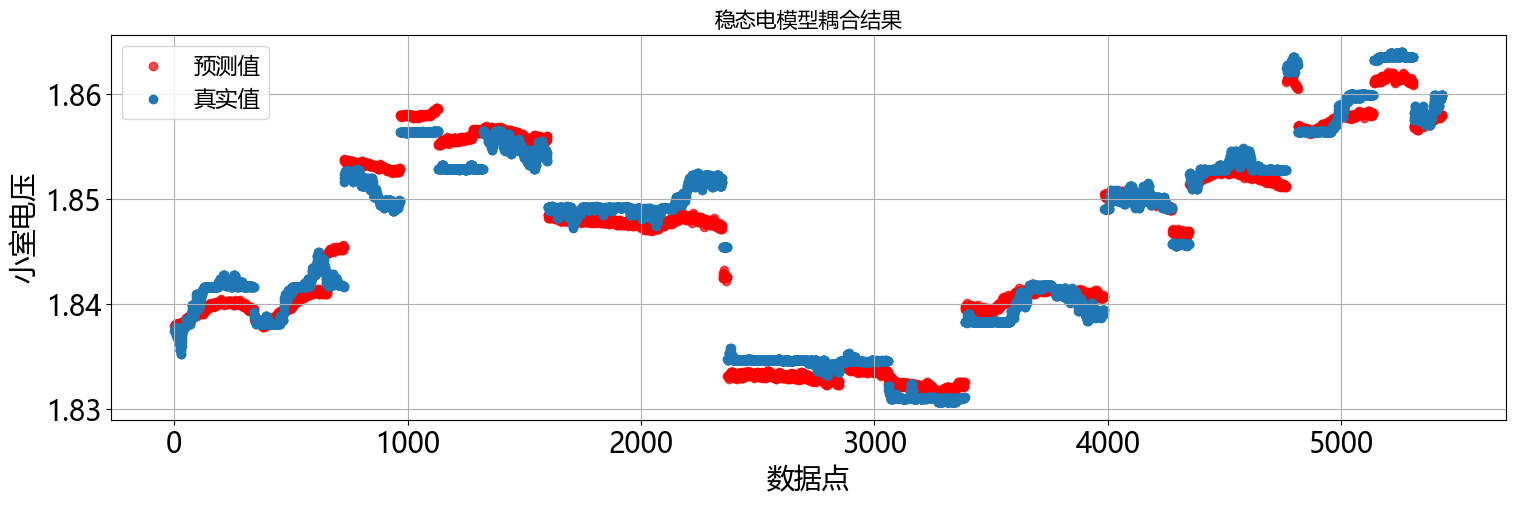

In [76]:
V_pred = cell_voltage_cal_empirical_formula(statistics=statistics_torch,
                                            **params)
V_pred_np = V_pred.cpu().detach().numpy()
cell_voltage_observed_np = cell_voltage_observed_torch.cpu().detach().numpy()

fig, ax1 = plt.subplots(figsize=(18,5))

ax1.scatter(range(len(V_pred_np)), V_pred_np, alpha = 0.7, c = 'r', label = '预测值')
ax1.scatter(range(len(V_pred_np)), cell_voltage_observed_np, label = '真实值')
ax1.legend()

plt.title('稳态电模型耦合结果', fontsize = 15)
plt.xlabel('数据点')
plt.ylabel('小室电压')
plt.grid()

# 画极化曲线

In [77]:
t1=params['t1'].item()
t2=params['t2'].item()
t3=params['t3'].item()
r1=params['r1'].item()
r2=params['r2'].item()
s1=params['s1'].item()

c1=params['c1'].item()
c2=params['c2'].item()

In [78]:
print(params)

{'r1': Parameter containing:
tensor([8.1199e-05], device='cuda:0', requires_grad=True), 'r2': Parameter containing:
tensor([-9.5918e-07], device='cuda:0', requires_grad=True), 's1': Parameter containing:
tensor([0.0794], device='cuda:0', requires_grad=True), 't1': Parameter containing:
tensor([0.0636], device='cuda:0', requires_grad=True), 't2': Parameter containing:
tensor([10.2736], device='cuda:0', requires_grad=True), 't3': Parameter containing:
tensor([237.4201], device='cuda:0', requires_grad=True), 'c1': Parameter containing:
tensor([1.0175], device='cuda:0', requires_grad=True), 'c2': Parameter containing:
tensor([0.8187], device='cuda:0', requires_grad=True)}


In [79]:
  # 稳态电化学模型
def Static_Electrochemical_Model(Lye_temp, Temp_out, Current_density, Lye_flow, Pressure = 1.6):
    """电解电压的计算模型

    Args:
        Lye_temp (float): 进口温度，即碱液温度 ℃
        Temp_out (float): 出口温度℃
        Current_density (float): 电流密度 A/m2
        Lye_flow (float): 碱液流量 m3/h
        Pressure (float): 压力 MPa

    Returns:
        float: 电解小室电压 V
    """

    # 避免 T_in 或 T_out 为零
    Lye_temp = max(Lye_temp, 1e-10)
    Temp_out = max(Temp_out, 1e-10)

    lambda_flow = Lye_flow / Volume_active / 25 + 0.1

    temp_work = (1-lambda_flow) * Lye_temp * c1 + lambda_flow * Temp_out * c2

    # 避免 log 函数的负数输入
    log_input = max((t1 + t2 / temp_work + t3 / temp_work ** 2) * Current_density + 1, 1e-10)

    Vcell= 1.25 + (r1 + r2 * temp_work) * Current_density + s1 * math.log(log_input)

    return Vcell

In [80]:
df_choose_point = df_date_Hyzenis.copy()
df_choose_point = df_choose_point[[Cols.current_density, Cols.cell_voltage, Cols.temp_out, Cols.lye_temp]]
df_choose_point_result = df_choose_point[(df_choose_point[Cols.temp_out] >= 84.9) & (df_choose_point[Cols.temp_out] <= 85.1) & (df_choose_point[Cols.lye_temp] >= 65.9) & (df_choose_point[Cols.lye_temp] <= 66.1)]

print(df_choose_point_result)

      current_density  cell_voltage   temp_out   lye_temp
3080      3243.830983      1.834625  84.960938  66.080727
3081      3243.830983      1.834607  84.939240  66.080727
3082      3243.830983      1.834625  84.939240  66.080727
3083      3243.830983      1.834625  84.939240  66.080727
3084      3243.830983      1.834625  84.939240  66.080727
3085      3239.366735      1.834625  84.939240  66.080727
3086      3243.830983      1.834625  84.939240  66.080727
3087      3243.830983      1.834625  84.939240  66.080727
3088      3243.830983      1.834625  84.939240  66.080727
3089      3243.830983      1.834625  84.939240  66.080727
3090      3243.830983      1.834625  84.939240  66.059029
3091      3243.830983      1.834275  84.939240  66.059029
3092      3243.830983      1.833907  84.939240  66.059029
3093      3243.830983      1.833540  84.928391  66.059029
3094      3243.830983      1.833172  84.928391  66.059029
3095      3243.830983      1.833172  84.906685  66.059029
3096      3243

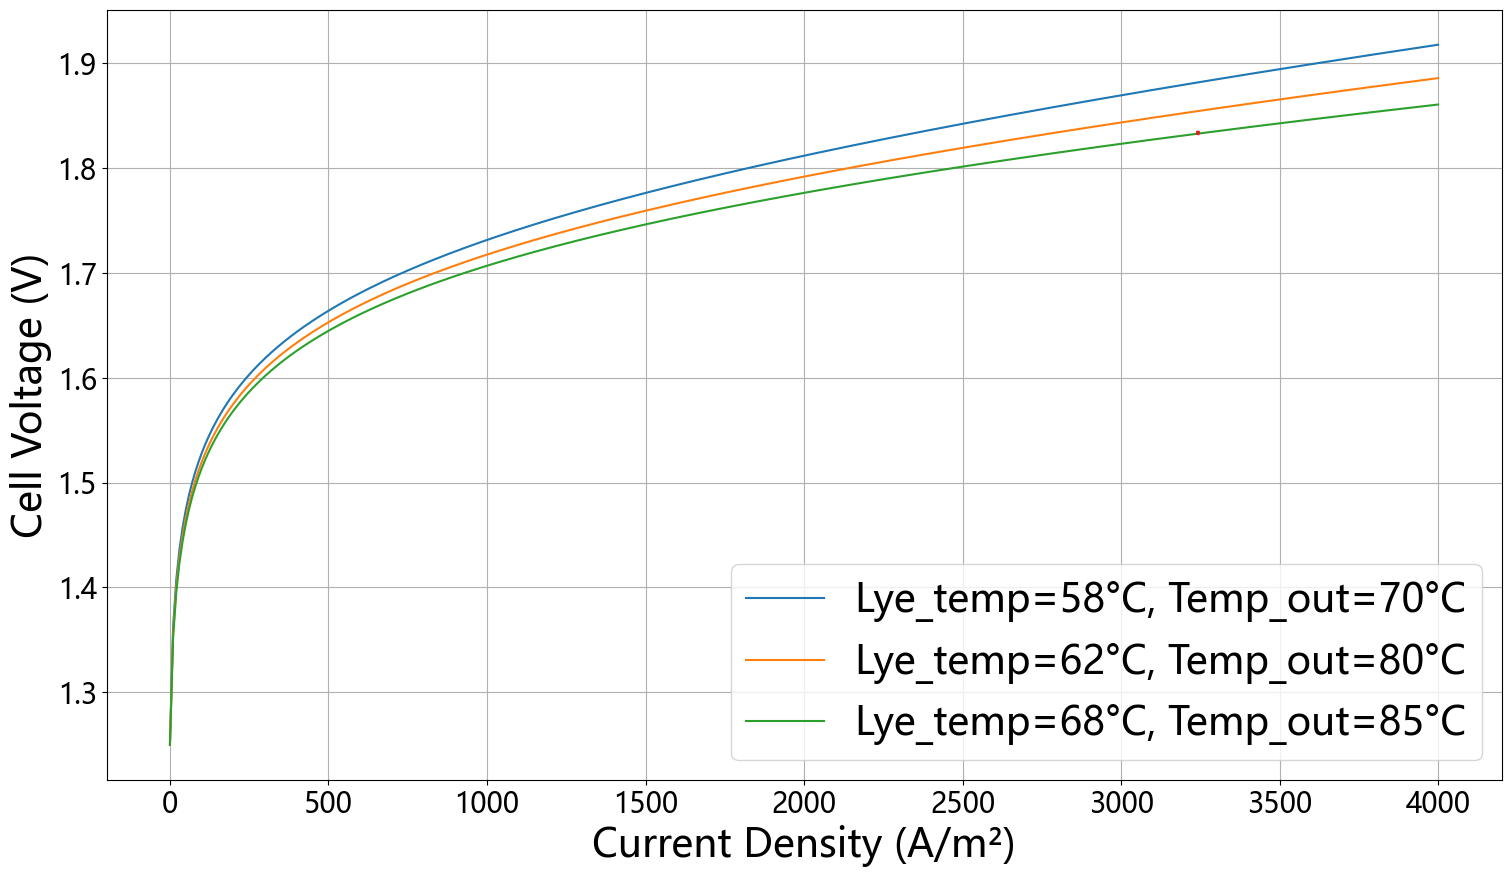

In [81]:
# 定义电流密度范围
current_densities = np.linspace(0, 4000, 400)

# 定义温度组合
temperature_combinations = [(58, 70), (62, 80), (68, 85)]

# 碱液流量和压力
Lye_flow = 0.4
Pressure = 1.6

# 初始化绘图
plt.figure(figsize=(18, 10))

# 遍历不同的温度组合
for Lye_temp, Temp_out in temperature_combinations:
    # 计算每个电流密度下的电池电压
    voltages = []
    for Current_density in current_densities:
        Vcell = Static_Electrochemical_Model(Lye_temp, Temp_out, Current_density, Lye_flow)
        voltages.append(Vcell)

    # 绘制极化曲线
    plt.plot(current_densities, voltages, label=f'Lye_temp={Lye_temp}°C, Temp_out={Temp_out}°C')

plt.plot(df_choose_point_result[Cols.current_density], df_choose_point_result[Cols.cell_voltage])

# 设置图表标题和标签
# plt.title('Polarization Curves at Different Temperature Combinations')
plt.xlabel('Current Density (A/m²)', fontsize=28)
plt.ylabel('Cell Voltage (V)', fontsize=28)
plt.legend(loc='lower right', fontsize=28)
plt.grid(True)

# 显示图表
plt.show()

In [94]:
from sklearn.metrics import r2_score

r2 = r2_score(V_pred_np, cell_voltage_observed_np)
print(r2)

0.9667070508003235


Text(1.862, 1.832, 'R$^2$=0.967\nMSE=2.667E-6')

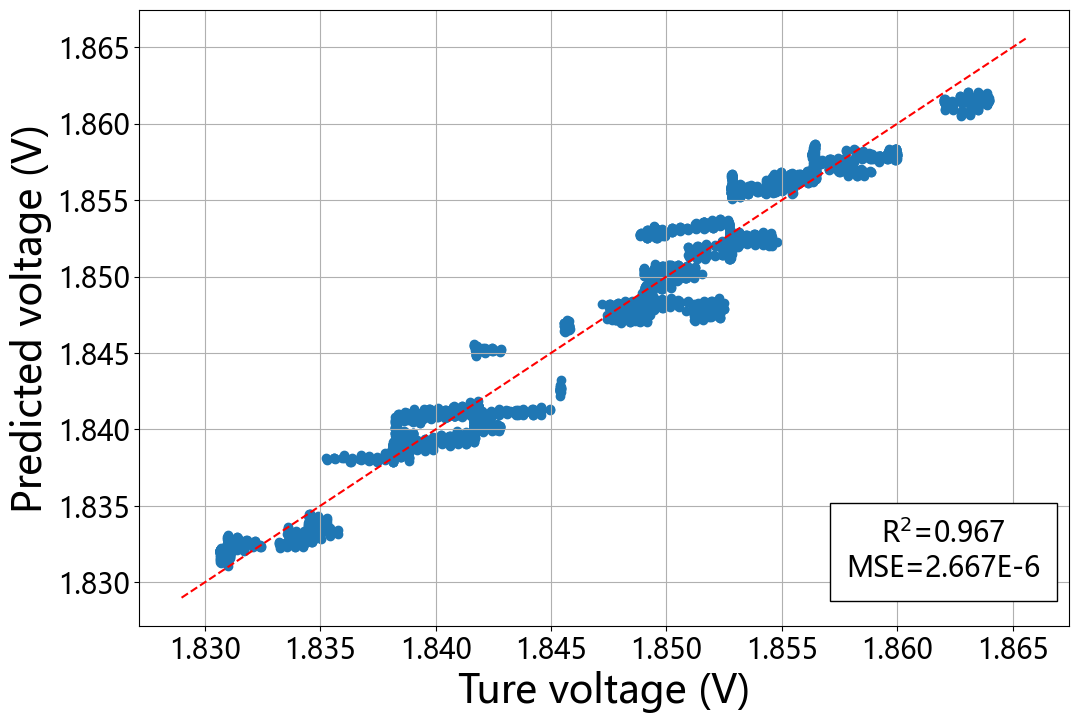

In [95]:
plt.figure(figsize=(12,8))
plt.scatter(cell_voltage_observed_np, V_pred_np)
# plt.title('稳态电模型预测结果')
plt.xlabel('Ture voltage (V)', fontsize=28)
plt.ylabel('Predicted voltage (V)', fontsize=28)
# 获取当前的 Axes 对象
ax = plt.gca()
# 获取坐标轴的范围
x_min, x_max = ax.get_xlim()
y_min, y_max = ax.get_ylim()
# 确定对角线的端点
diag_min = min(x_min, y_min)
diag_max = max(x_max, y_max)
plt.grid(True)
# 绘制对角线
plt.plot([diag_min, diag_max], [diag_min, diag_max], color='red', linestyle='--')

# 绘制空白框并添加文本
plt.text(
    x=1.862, y=1.832,  # 文本框中心坐标（相对画布比例，0-1范围）
    s="R$^2$=0.967\nMSE=2.667E-6",  # 文本内容
    fontsize=20,    # 字体大小
    ha='center',    # 水平居中
    va='center',    # 垂直居中
    bbox=dict(      # 空白框样式设置
        facecolor='white',  # 框内填充色（白色=空白）
        edgecolor='black',  # 边框颜色
        boxstyle='square,pad=0.6'  # 框样式（round=圆角，pad=内边距）
    )
)

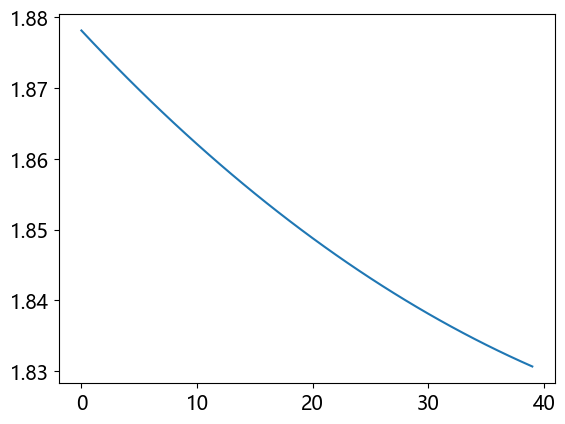

In [21]:
lye_flow_array = np.arange(0.3, 0.5, 0.005)
lye_temp_array = np.linspace(55, 75, len(lye_flow_array))
voltage_array = np.array([])

for i in range(len(lye_flow_array)):

    voltage = Static_Electrochemical_Model(Lye_temp = lye_temp_array[i],
                                                       Temp_out = 85,
                                                       Current_density = 3500,
                                                       Lye_flow = lye_flow_array[i],
                                                       Pressure=1.6)
    voltage_array = np.append(voltage_array, voltage)

plt.plot(voltage_array)